In [5]:
### Somatic calling without a matched normal sample
# Tram, Billie, Kevin
# Sep 8, 2023

## This script is to train a model using truth labels from tumor-only somatic calls generated 
# from the current checkGermline.paired 
# To classify somatic and germline calls WITHOUT having a matched normal PBMC 

# It build upon the script to detect CHIP based on the Fairchild paper, made by Billie Gould and Kevin 


#setwd("/Users/users/Documents/Code")

# Packages
library(dplyr)
library(ggplot2)
library(RColorBrewer)
#library(gridExtra)
library(tidyr)
library(caret)
#library(ROCR)
library(pROC)
#library(knitr)
library(glmnet)
## modification of methods found in Fairchild et al. 2023 code:
# https://zenodo.org/record/7618106

# function for harmonizing all patient ID numbers across files
#source("CHIP/fix_PIDs.R")
source("~/Desktop/Moffitt_2022/fix_PIDs.R")
sessionInfo()

Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7



R version 4.3.0 (2023-04-21)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Ventura 13.5.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] glmnet_4.1-7          Matrix_1.6-0          pROC_1.18.4          
 [4] caret_6.0-94          lattice_0.21-8        tidyr_1.3.0          
 [7] ggplot2_3.4.2         ComplexHeatmap_2.16.0 maftools_2.16.0      
[10] eulerr_7.0.0          RColorBrewer_1.1-3    glue_1.6.2           
[13] stringr_1.5.0         dplyr_1.1.2          

loaded via a namespace (and not attached):
 [1] tidyselect

In [42]:
# test data sets
all.snv.plasma <- read.csv("../CHIP/PRDC-MOFFITT-MIBC-22002-ATLAS_Variant_all_07-27-2023_2023-07-27_plasma_marked.csv", as.is=T) #ATLAS
all.snv.plasma = all.snv.plasma %>% mutate(PatientID.old = PatientID,
                                           PatientID = fix_PIDs(PatientID.old))
table(all.snv.plasma$VariantType.old)
table(all.snv.plasma$VariantType)
nrow(all.snv.plasma)
table(all.snv.plasma$SpecimenType)
all.snv.plasma %>% group_by(PatientID) %>% summarize(n_mutations=n()) 

### Matched normal pbmc # moved these lines up for clarity
all.pbmc = read.csv("../CHIP/PRDC-MOFFITT-MIBC-22002-WES_Variant_all_2022-12-28_pbmc.csv", as.is=T)
table(all.pbmc$SpecimenType)
# fix old patient id numbers in this file
all.pbmc = all.pbmc %>% mutate(PatientID.old = PatientID,
                               PatientID = fix_PIDs(PatientID.old))
# any patients without germline data?
stopifnot(all(unique(all.snv.plasma$PatientID) %in% unique(all.pbmc$PatientID)))
dim(all.snv.plasma)
head(all.snv.plasma)
# Add patient ID to VariantID for more unique ID
all.snv.plasma <- all.snv.plasma %>% mutate(VariantID.2=paste0(PatientID, ":", VariantID))
length(unique(all.snv.plasma$VariantID.2)) # make sure each variants get unique ID. matches number of rows (n=55644)


# Read in tumor only ffpe
all.snv.tumor <- read.csv("../CHIP/PRDC-MOFFITT-MIBC-22002-WES_Variant_all_2022-12-28_ffpe_marked.csv", as.is=T)
all.snv.tumor = all.snv.tumor %>% mutate(PatientID.old = PatientID,
                                         PatientID = fix_PIDs(PatientID.old))
all.snv.tumor %>% group_by(PatientID) %>% summarize(n_mutations=n())

# any patients without tumor data?
# stopifnot(all(unique(all.snv.plasma$PatientID) %in% unique(all.snv.tumor$PatientID))) 

# some patients don't have tumor data, filter these out
all.snv.plasma = all.snv.plasma %>% filter(PatientID %in% unique(all.snv.tumor$PatientID))

dim(all.snv.plasma)




 [1] "173736" "172592" "175702" "89200"  "174438" "172956" "174280" "172109"
 [9] "170762" "170594" "172163" "173129" "171660" "175253" "171351" "175743"
[17] "172422" "171126" "173657" "174688" "175827" "173149" "173983"



 CHIP mutations        Germline Likely germline  Likely somatic         Somatic 
             56           47018            1928            6629              13 


       CHIP mutations              Germline     Likely background 
                   33                 50450                  1216 
Likely CHIP mutations       Likely germline        Likely somatic 
                   36                  1101                   600 
              Somatic 
                 2208 

[1] 55644


Plasma 
 55644 

PatientID,n_mutations
<chr>,<int>
170594,2634
170762,2448
171126,2288
171351,2515
171660,2478
172109,2359
172163,2467
172422,2379
172592,2337



Buffy Coat 
    591299 

 [1] "173983" "170594" "172163" "172401" "172592" "172422" "172403" "173149"
 [9] "174438" "174688" "170762" "171351" "172109" "172956" "173129" "171660"
[17] "173736" "174280" "173657" "175253" "89200"  "175702" "175743" "171126"
[25] "175827"


[1] 55644   101

,X,seqnames,start,end,width,strand,ref,alt,totalDepth,refDepth,⋯,totalDepth.Baseline,dscnt.Baseline.filtered,altDepth.Baseline,altDepth.Baseline.filtered,AF.Baseline,odds.ratio,pvalue,MAF.diff,VariantType.old,finalKeep.old
,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,1,chr1,11187893,11187893,1,*,T,C,3769,4,⋯,922,28,922,736,100.0,0.9989388,0.5185111,-0.10612895,Germline,TRUE
2,2,chr1,11205058,11205058,1,*,C,T,3506,26,⋯,512,13,508,408,99.2,1.0004027,0.5110042,0.05841415,Germline,TRUE
3,3,chr1,11288758,11288758,1,*,G,A,3818,27,⋯,1013,31,1008,844,99.5,0.9978536,0.5270965,-0.20717653,Germline,TRUE
4,4,chr1,11301714,11301714,1,*,A,G,2724,7,⋯,752,16,752,648,100.0,0.9974305,0.5292151,-0.25697504,Germline,TRUE
5,5,chr1,114224782,114224782,1,*,A,ATT,3391,2276,⋯,396,2,134,118,33.8,0.9717162,0.6296152,-0.91884400,Germline,TRUE
6,6,chr1,117690272,117690272,1,*,G,A,2978,11,⋯,502,8,500,411,99.6,1.0003092,0.5119251,0.03062458,Germline,TRUE


[1] 55644

 [1] "173149" "170762" "89200"  "171660" "172109" "172163" "172401" "172422"
 [9] "175253" "175743" "171126" "174688" "172403" "173736" "175827" "173129"
[17] "173983" "172592" "172956" "174280" "173657" "175702"


PatientID,n_mutations
<chr>,<int>
170762,30738
171126,26610
171660,29976
172109,33182
172163,28645
172401,28218
172403,27593
172422,27628
172592,26958


[1] 48097   102

In [43]:
########################################################################
############### ADD MCLAUGHIN ET AL. FEATURES TO DATASET ###############
########################################################################

# https://www.nature.com/articles/s41698-022-00340-1

########## 1. t_depth: ##########
# The number of reads at the alt allele locus
# We can use either altDepth, or altDepth.Baseline.filtered   ## here "baseline" -> matched pbmc sample.


########## 2. t_maj_allele: ##########
# The fraction of reads corresponding to the most abundance allele.
# In their paper: (the greatest VAF among all observed alleles at the variant’s locus) across entire dataset  ## max VAF within patient, or across patients?
# VariantFreq Column = Alt depth divided by the total depth x 100

# Across ALL patient samples at each variant locus. Find the max VAF across the dataset
all.snv.plasma <- as.data.frame(all.snv.plasma %>% group_by(seqnames, start, end) %>% mutate(t_maj = max(VariantFreq)))
unique(all.snv.plasma$t_maj[all.snv.plasma$seqnames == "chr16" & all.snv.plasma$start == "136888"]) 
# Check that for the same position across patients, should have the same t_maj


########## 3. t_alt_freq: ##########
# The fraction of reads corresponding to the alternate allele
# I think this is just VAF (VariantFreq) which is always the alt allele


########## 4. max_cosmic_count:	##########
# The number of times this allele has been observed in the COSMIC
# Use the COSMIC.CNT column

# First, we need to change the COSMIC.CNT column to integer (it is now character)
all.snv.plasma$COSMIC.CNT <- as.integer(all.snv.plasma$COSMIC.CNT)
class(all.snv.plasma$COSMIC.CNT)

all.snv.plasma <- all.snv.plasma %>% group_by(seqnames, start, end, alt) %>% # added alt here since sometimes multiple alleles at a site
  mutate(max_COSMIC_CNT = max(COSMIC.CNT)) %>% 
  mutate(max_COSMIC_CNT=ifelse(is.na(max_COSMIC_CNT), 0, max_COSMIC_CNT))
# If not in COSMIC = NA = set to zero


########## 5. pop_max: ########## 
# The maximum population frequency of the allele across multiple germline databases
## CHECK dbNSNP?
## https://www.internationalgenome.org/faq/how-do-i-find-out-information-about-a-single-variant/

## get annotation pop freqs via ANNOVAR for this


########## 6. snp_vaf_bin_00: ##########
# The number of informative SNPs in the local copy number neighborhood with VAF between 0 and 0.05

# Need to get copy number neighborhoods
# Filter for VAF bin
# Count how many SNPs are there
# germline variant databases and copy-number segments, we identify neighboring heterozygous germline SNPs of similar copy number, and create a histogram of variant counts with 20 non- overlapping VAF bins 
# the copy number for each variant is represented by features derived from copy-number segmentation data and variant calls. Briefly, using germline variant databases and copy-number segments, we identify neighboring heterozygous germline SNPs of similar copy number, and create a histogram of variant counts with 20 non- overlapping VAF bins (see “Methods”).

# possible features to use
# CopyNumber column
# average CopyNumber for this snv and other snvs within ~10 MB (?could use average human genome LD MB value here) for the patient
# local 1MB bin CN estimate and/or coverage zscore from additional LP-WGS data


########## 7. Count: ##########
# the total number of variants to classify in the sample
# For each patient, find the total number of sites in the atlas data (both variant and germline) 

# why is this biologically relevant? 

# Count total number of row (all variants)
#all.snv.plasma <- all.snv.plasma %>% group_by(PatientID) %>% add_count(name="allVarCount") ###### omit this line
all.snv.plasma %>% group_by(PatientID) %>% summarise(n()) # Check that each patient has unique total Variant count



########## 8. Ontology: ##########
# Categorical Coding mutation subclassification. McLaughlin's categories: inframe_indel, missense, nonsense, frame_shift_indel
# Looks like we can use the "Consequence" column of the data. Maybe in the future we bin these?

# here is a previously designed binning function for this. you can also create your own reclassification and 
#insert as var.reduc.set: 
source("../puffin/R/concordance_oncoprint.R")
all.snv.plasma <- all.snv.plasma %>% mutate(Consequence.short=recode.variants(Consequence, 
                                                                              var.reduc.set = "consequence_reduced"))

dim(all.snv.plasma) # should be 105 columns with new features added
names(all.snv.plasma)[100:105]




[1] 99.93683

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


[1] "integer"

PatientID,n()
<chr>,<int>
170762,2448
171126,2288
171660,2478
172109,2359
172163,2467
172422,2379
172592,2337
172956,2461
173129,2332


[1] 48097   105

[1] "VariantType.old"   "finalKeep.old"     "VariantID.2"      
[4] "t_maj"             "max_COSMIC_CNT"    "Consequence.short"

In [ ]:
###### NOTE!!! YOU DONT NEED TO RUN THIS AGAIN, JUST SKIP TO NEXT CHUNK. #######
# This is just to show the script for generating this info

##################### USING mutSigExtractor PACKAGE ####################
#https://cran.r-project.org/web/packages/mutSignatures/vignettes/get_sarted_with_mutSignatures.html


## Bioconductor packages required by mutSigExtractor
library('BSgenome') ## Install genome parser
library('BSgenome.Hsapiens.UCSC.hg19') ## Install the default genome
library('GenomeInfoDb')
# install.packages("devtools")
# devtools::install_github("dami82/mutSignatures", force = TRUE, build_vignettes = TRUE) # NOTE: must install LATEST VERSION 
# devtools::install_github("UMCUGenetics/mutSigExtractor", force = T)
library(mutSigExtractor)
library(mutSignatures)
library(dplyr)
library(reshape2)
library(kableExtra)
library(ggplot2)
library(gridExtra)

# prep hg19
hg19 <- BSgenome.Hsapiens.UCSC.hg19

# If the set of mutational signatures is already known, it is possible to use mutSignatures to estimate the contribution of each mutational pattern in a collection of samples

# Load file # I think it can only be SNV, not indels - so we will use our snv filtered file
vars_plasma <- read.delim("all.snv.plasma.txt", header = T, as.is=T, sep="\t") # read in current plasma SNV
dim(vars_plasma)

### NOTE: POS needs to be in characters... for some reason, otherwise error
vars_plasma$start <- as.character(vars_plasma$start) 

# 94 rows excluded (that have missing info "missing value where TRUE/FALSE needed" or no "seqnames" for some reason may need to check original file)
input <- attachContext(mutData = vars_plasma,
                             chr_colName = "seqnames",
                             start_colName = "start",
                             end_colName = "start",
                             nucl_contextN = 3,
                             BSGenomeDb = hg19)

# check which 94 rows were removed
x <- input %>% select(-(context))
dim(x)
dim(vars_plasma)

removed <- anti_join(vars_plasma, x, by=c("seqnames", "VariantID.2", "PatientID"))


# Visualize
head(input) %>% kable() %>% kable_styling(bootstrap_options = "striped")


# Remove mismatches # Remove mutation types that do not match the expected nucleotidic context.
# (Removing 3516 rows because of mismatch)
# Maybe in the future, we skip this step & keep the unexpected ones becuase they are attributed to unexpected somatic mutations?
x <- removeMismatchMut(mutData = input,              # input data.frame
                       refMut_colName = "ref",       # column name for ref base
                       context_colName = "context",  # column name for context
                       refMut_format = "N")    

# Check which rows were removed
removed <- anti_join(input, x, by=c("seqnames", "VariantID.2", "PatientID"))
table(input$VariantType)
table(x$VariantType)
table(removed$VariantType) #all are indels

# Compute mutType
x <- attachMutType(mutData = x,                      # as above
                   ref_colName = "ref",              # column name for ref base
                   var_colName = "alt",              # column name for mut base
                   context_colName = "context") 


# Visualize head
head(x) %>% kable() %>% kable_styling(bootstrap_options = "striped")
dim(x)

#### For each variant we want to group it into the 6 categories (like in McLaughlin)
# In McLaughlin, they only use these categories: C>G, C>T, T>A, T>C, T>G, non-SBS
# We have more than that... I'm adding C>A

# I would consider annotating ALL 12 possible transitions/transversions here, and let the model determine 
# which ones are important for our data set. Otherwise, is there a biological reason only these 6 are used?

cdf <- x %>% mutate(mutMotif = case_when(
  grepl("C>G", mutType, ignore.case = TRUE) ~ "C>G",  
  grepl("C>T", mutType, ignore.case = TRUE) ~ "C>T", 
  grepl("T>A", mutType, ignore.case = TRUE) ~ "T>A", 
  grepl("T>C", mutType, ignore.case = TRUE) ~ "T>C", 
  grepl("T>G", mutType, ignore.case = TRUE) ~ "T>G", 
  grepl("C>A", mutType, ignore.case = TRUE) ~ "C>A",
  TRUE ~ "nonSBS"  # everything else
))

unique(cdf$mutMotif) # Check that we've captured them all
cdf[cdf$mutMotif == "nonSBS", ] # Looks like indel cases

# Write table
#write.table(cdf, "tri-mut-context.txt", col.names = T, row.names = F, sep = "\t", quote = F)

mut <- cdf

In [44]:
names(mut)
names(all.snv.plasma)

[1] "VariantID.2" "context"     "mutType"     "mutMotif"

[1] "X"                          "seqnames"                  
  [3] "start"                      "end"                       
  [5] "width"                      "strand"                    
  [7] "ref"                        "alt"                       
  [9] "totalDepth"                 "refDepth"                  
 [11] "altDepth"                   "sampleNames"               
 [13] "VariantFreq"                "SYMBOL"                    
 [15] "GeneID"                     "Feature"                   
 [17] "HGVSc"                      "HGVSp"                     
 [19] "Amino_acids"                "Codons"                    
 [21] "BIOTYPE"                    "EXON"                      
 [23] "INTRON"                     "Consequence"               
 [25] "DISTANCE"                   "Existing_variation"        
 [27] "IMPACT"                     "VARIANT_CLASS"             
 [29] "CLIN_SIG"                   "Clinvar"                   
 [31] "dbSNP"                      "COSMIC"                    
 [33] "COSMIC.CNT"                 "genome1000"                
 [35] "AF"                         "CANONICAL"                 
 [37] "filteredCnt"                "DSCnt"                     
 [39] "filteredDSCnt"              "pseudoDSCnt"               
 [41] "altLOD"                     "Qscore"                    
 [43] "entropy"                    "avgEntropy"                
 [45] "filtered_tlen_mean"         "tlen.ratio"                
 [47] "filtered_toend_numunique"   "filtered_total_base_count" 
 [49] "filterVarType"              "repeatRegion"              
 [51] "white.list"                 "wl.tier"                   
 [53] "MNV"                        "GC.Percent"                
 [55] "tandemRepeat"               "AF.th"                     
 [57] "AF.diff"                    "bgFilter"                  
 [59] "generalFilter"              "localVariantFilter"        
 [61] "ReadEndFilter"              "DS.filter"                 
 [63] "highQ.ratio"                "fc.ds.ratio"               
 [65] "CopyNumber"                 "zScore.cnv"                
 [67] "coVariant"                  "ol.coVariant"              
 [69] "snvmember"                  "mergedVariant"             
 [71] "coVariantFilter"            "sideVariant"               
 [73] "sideVariant.AF.ratio"       "prevalenceInternal"        
 [75] "filterPrevalence"           "filterScore"               
 [77] "finalKeep"                  "VariantID"                 
 [79] "sampleDir"                  "VariantType"               
 [81] "depth"                      "FilterType"                
 [83] "sampleFolder"               "PatientID"                 
 [85] "externalSampleID"           "trialVisitNum"             
 [87] "SpecimenType"               "ID"                        
 [89] "highFrequent.inbatch"       "concordant"                
 [91] "PatientID.old"              "totalDepth.Baseline"       
 [93] "dscnt.Baseline.filtered"    "altDepth.Baseline"         
 [95] "altDepth.Baseline.filtered" "AF.Baseline"               
 [97] "odds.ratio"                 "pvalue"                    
 [99] "MAF.diff"                   "VariantType.old"           
[101] "finalKeep.old"              "VariantID.2"               
[103] "t_maj"                      "max_COSMIC_CNT"            
[105] "Consequence.short"

In [45]:
########## 9. trinucleotide_context: ##########
# The three surrounding nucleotides (1 bp upstream, the locus itself, and 1 bp downstream) in the reference genome for the SNV (non_SBS = non-single base-pair substitution, i.e, indels)

# Save the all.snv.plasma data as it is -- use this as input for the MutSig scripts.
#write.table(all.snv.plasma, "all.snv.plasma.txt", col.names = T, row.names = F, quote = F)


# From mutationSignature workflow:
# "context" column
# R script: "get-trinucleotide.R"

# Load in our trinucleotide context and mutation motifs
mut <- read.delim("tri-mut-context.txt", sep = "\t", header = T, as.is=T)
mut <- mut %>%  select(VariantID.2, context, mutType, mutMotif) # Just grab relevant info to join new columns
mut$VariantID.2 <- as.character(mut$VariantID.2)

head(mut)

# Merge tri and mut context to ALL PLASMA variants
all.snv.plasma <- all.snv.plasma %>% left_join(mut, by="VariantID.2")

dim(all.snv.plasma)
names(all.snv.plasma[100:length(all.snv.plasma)]) # Should see our new columns here
# might need this instead?
names(all.snv.plasma)[100:ncol(all.snv.plasma)]

########## substitution_type: ##########	
# Which of the 6 unique transition and transversion types characterizes the single-base-substitution (non-SBS for indels)
# C>G, C>T, T>A, T>C, T>G, non-SBS, C>A

# From mutationSignature workflow: "mutSigs-trinucleotide.R"

## Save new plasma variants 
#write.table(all.snv.plasma, "all.snv.plasma.McL.txt", col.names = T, row.names = F, sep = "\t", quote = F)

class(all.snv.plasma$PatientID)

#mut <- read.delim("tri-mut-context.txt", sep = "\t", header = T, as.is=T)
# Merge on the new trinucleotide/motif columns. NA for if not available for variants.
#all.snv.plasma <- all.snv.plasma  %>% left_join(mut, by="ID", suffix = c("", ".drop")) %>%
#  select(-ends_with(".drop"))
#head(all.snv.plasma)


dim(all.snv.plasma)
names(all.snv.plasma)[100:length(all.snv.plasma)] # Should see the tri-nucle, mutation Type, and signature columns added

## not sure if these trinuc signatures are relevant for indels. may want to set mutType for these as just "indel"
all.snv.plasma = all.snv.plasma %>% mutate(mutType=ifelse(nchar(ref)>1 | nchar(alt)>1, "indel", mutType))

#############################################################################
################### COMPLETED ADDING MCLAUGHLIN FEATURES  ###################
#############################################################################

,VariantID.2,context,mutType,mutMotif
,<chr>,<chr>,<chr>,<chr>
1,173736:chr1:11187893:T:C,ATC,A[T>C]C,T>C
2,173736:chr1:11205058:C:T,TCG,T[C>T]G,C>T
3,173736:chr1:11288758:G:A,CGT,A[C>T]G,C>T
4,173736:chr1:11301714:A:G,CAT,A[T>C]G,T>C
5,173736:chr1:114224782:A:ATT,GAT,A[T>AAT]C,T>A
6,173736:chr1:117690272:G:A,CGA,T[C>T]G,C>T


[1] 48097   108

[1] "VariantType.old"   "finalKeep.old"     "VariantID.2"      
[4] "t_maj"             "max_COSMIC_CNT"    "Consequence.short"
[7] "context"           "mutType"           "mutMotif"

[1] "VariantType.old"   "finalKeep.old"     "VariantID.2"      
[4] "t_maj"             "max_COSMIC_CNT"    "Consequence.short"
[7] "context"           "mutType"           "mutMotif"

[1] "character"

[1] 48097   108

[1] "VariantType.old"   "finalKeep.old"     "VariantID.2"      
[4] "t_maj"             "max_COSMIC_CNT"    "Consequence.short"
[7] "context"           "mutType"           "mutMotif"

In [60]:
# create variant identifier columns
# In the CHIP data, it made sense to check within just somatic calls -- but for us, we want to check ALL plasma variants
all.snv.plasma.McL = all.snv.plasma %>% 
  mutate(VariantID.2=paste0(PatientID, ":", VariantID),
  Plasma.VariantFreq = VariantFreq) 

all.snv.tumor_ = all.snv.tumor %>% 
  mutate(VariantID.2=paste0(PatientID, ":", VariantID), Tumor.VariantFreq = VariantFreq, Tumor.VariantType = VariantType) %>%
  select(VariantID.2, Tumor.VariantFreq, Tumor.VariantType) # Add the tumor variant type and freq

all.pbmc_ = all.pbmc %>% mutate(VariantID.2=paste0(PatientID, ":", VariantID), Germ.VariantFreq = VariantFreq,
                               Germ.VariantType = VariantType) %>% # might need his info, mostly Germline, some might be CHIP
  select(VariantID.2, Germ.VariantFreq, Germ.VariantType)

In [61]:
# for variants with Germ.VariantFreq values that are NA (missing from germline sample), set Germ.VariantFreq to 0.0%
all.snv.plasma.McL = all.snv.plasma.McL %>% left_join(all.pbmc_, by="VariantID.2") %>%
      mutate(Germ.VariantFreq=ifelse(is.na(Germ.VariantFreq), 0, Germ.VariantFreq),
             in.pbmc = factor(Germ.VariantFreq>0)) # Create another column for updated germline freq for somatic calls 

all.snv.plasma.McL = all.snv.plasma.McL %>% left_join(all.snv.tumor_, by="VariantID.2") %>%
  mutate(Tumor.VariantFreq=ifelse(is.na(Tumor.VariantFreq), 0, Tumor.VariantFreq),
         in.tumor = factor(Tumor.VariantFreq > 0) #,
         #Tumor.VariantType=ifelse(is.na(Tumor.VariantType), "Germline", Tumor.VariantType)
        ) 
# If not found in tumor, set to Germline? CHECK WITH BILLIE  
## I don't think we need this last feature in the model, it is just for reference later, so maybe leave as NA

table(all.snv.plasma.McL$in.pbmc) # 39585 variants overlap PBMC + plasma ATLAS
table(all.snv.plasma.McL$in.tumor) # 42340 variants overlap FFPE + plasma ATLAS . . . these are mostly germline mutations


 TRUE FALSE 
39585  8512 


 TRUE FALSE 
42340  5757 

In [62]:
dim(all.snv.plasma.McL)

# View all of the new columns we've added onto the plasma ATLAS dataset
names(all.snv.plasma.McL)[100:length(all.snv.plasma.McL)]

### 
# somatic Tumor.VariantType counts are low because most of the tumor variants are not detectable in the plasma;
# or Tumor.VariantType==NA.
table(all.snv.plasma.McL$PatientID, all.snv.plasma.McL$Tumor.VariantType, useNA="always") 
# here we have about ~120 somatic variants in the plasma per patient
table(all.snv.plasma.McL$PatientID, all.snv.plasma.McL$VariantType, useNA="always")



[1] 48097   115

[1] "VariantType.old"    "finalKeep.old"      "VariantID.2"       
 [4] "t_maj"              "max_COSMIC_CNT"     "Consequence.short" 
 [7] "context"            "mutType"            "mutMotif"          
[10] "Plasma.VariantFreq" "Germ.VariantFreq"   "Germ.VariantType"  
[13] "in.pbmc"            "Tumor.VariantFreq"  "Tumor.VariantType" 
[16] "in.tumor"

        
         CHIP mutations Germline Likely background Likely CHIP mutations
  170762              0     2144                38                     1
  171126              1     1959                26                     0
  171660              0     2140                36                     0
  172109              0     2104                16                     0
  172163              0     2170                28                     0
  172422              0     2093                24                     0
  172592              0     2032                17                     0
  172956              0     2105                27                     0
  173129              0     1972                32                     0
  173149              0     2051                34                     1
  173657              0     1830                52                     0
  173736              0     2085                25                     0
  173983              0     2151          

        
         CHIP mutations Germline Likely background Likely CHIP mutations
  170762              3     2201                62                     2
  171126              1     2077                75                     2
  171660              3     2234                60                     2
  172109              2     2178                61                     1
  172163              0     2263                61                     1
  172422              0     2166                52                     2
  172592              1     2146                32                     2
  172956              2     2240                62                     1
  173129              0     2109                51                     1
  173149              0     2100                67                     2
  173657              1     2090                47                     2
  173736              1     2202                59                     1
  173983              0     2146          

In [63]:
# indx <- which(grepl("somatic|chip", all.snv.plasma.McL$VariantType)) ## need ignore.case=T here
# test <- all.snv.plasma.McL[indx,]
# head(test)
# dim(test) # Looks to be 600 variants that were determined somatic/chip after the checkGermline.paired in the matched label
table(all.snv.plasma.McL$VariantType) # about 1400 variants labeled as somatic/likely somatic/chip by the existing pipeline


       CHIP mutations              Germline     Likely background 
                   26                 43584                  1059 
Likely CHIP mutations       Likely germline        Likely somatic 
                   31                   947                   541 
              Somatic 
                 1909 

In [65]:
## Remove patients who dont have all three PLASMA + PBMC + TUMOR

## QUESTION BILLIE: Does this make sense to filter? #Yes!, but we already checked for that before merging the data sets together above.

# commonPatient <- intersect(intersect(unique(all.snv.plasma.McL$PatientID), unique(all.snv.tumor$PatientID)), unique(all.snv.pbmc$PatientID))
# commonPatient
# all.snv.plasma.McL.comm <- all.snv.plasma.McL %>%  filter(PatientID %in% commonPatient)

# table(all.snv.plasma.McL.comm$PatientID, all.snv.plasma.McL.comm$Tumor.VariantType)

### NOTE: These patients have very few tumor somatic calls that overlap with ATLAS.... ## true, see comment above

sort(names(all.snv.plasma.McL))

[1] "AF"                         "AF.Baseline"               
  [3] "AF.diff"                    "AF.th"                     
  [5] "alt"                        "altDepth"                  
  [7] "altDepth.Baseline"          "altDepth.Baseline.filtered"
  [9] "altLOD"                     "Amino_acids"               
 [11] "avgEntropy"                 "bgFilter"                  
 [13] "BIOTYPE"                    "CANONICAL"                 
 [15] "CLIN_SIG"                   "Clinvar"                   
 [17] "Codons"                     "concordant"                
 [19] "Consequence"                "Consequence.short"         
 [21] "context"                    "CopyNumber"                
 [23] "COSMIC"                     "COSMIC.CNT"                
 [25] "coVariant"                  "coVariantFilter"           
 [27] "dbSNP"                      "depth"                     
 [29] "DISTANCE"                   "DS.filter"                 
 [31] "DSCnt"                      "dscnt.Baseline.filtered"   
 [33] "end"                        "entropy"                   
 [35] "Existing_variation"         "EXON"                      
 [37] "externalSampleID"           "fc.ds.ratio"               
 [39] "Feature"                    "filtered_tlen_mean"        
 [41] "filtered_toend_numunique"   "filtered_total_base_count" 
 [43] "filteredCnt"                "filteredDSCnt"             
 [45] "filterPrevalence"           "filterScore"               
 [47] "FilterType"                 "filterVarType"             
 [49] "finalKeep"                  "finalKeep.old"             
 [51] "GC.Percent"                 "GeneID"                    
 [53] "generalFilter"              "genome1000"                
 [55] "Germ.VariantFreq"           "Germ.VariantType"          
 [57] "HGVSc"                      "HGVSp"                     
 [59] "highFrequent.inbatch"       "highQ.ratio"               
 [61] "ID"                         "IMPACT"                    
 [63] "in.pbmc"                    "in.tumor"                  
 [65] "INTRON"                     "localVariantFilter"        
 [67] "MAF.diff"                   "max_COSMIC_CNT"            
 [69] "mergedVariant"              "MNV"                       
 [71] "mutMotif"                   "mutType"                   
 [73] "odds.ratio"                 "ol.coVariant"              
 [75] "PatientID"                  "PatientID.old"             
 [77] "Plasma.VariantFreq"         "prevalenceInternal"        
 [79] "pseudoDSCnt"                "pvalue"                    
 [81] "Qscore"                     "ReadEndFilter"             
 [83] "ref"                        "refDepth"                  
 [85] "repeatRegion"               "sampleDir"                 
 [87] "sampleFolder"               "sampleNames"               
 [89] "seqnames"                   "sideVariant"               
 [91] "sideVariant.AF.ratio"       "snvmember"                 
 [93] "SpecimenType"               "start"                     
 [95] "strand"                     "SYMBOL"                    
 [97] "t_maj"                      "tandemRepeat"              
 [99] "tlen.ratio"                 "totalDepth"                
[101] "totalDepth.Baseline"        "trialVisitNum"             
[103] "Tumor.VariantFreq"          "Tumor.VariantType"         
[105] "VARIANT_CLASS"              "VariantFreq"               
[107] "VariantID"                  "VariantID.2"               
[109] "VariantType"                "VariantType.old"           
[111] "white.list"                 "width"                     
[113] "wl.tier"                    "X"                         
[115] "zScore.cnv"

In [71]:
# OK... moving on for now, but need to troubleshoot this because too few somatic calls in tumor truth set...

####
# Ground truth = VariantType is somatic/CHIP after germline matched normal pipeline in FFPE
# We are treating CHIP in same category as somatic here.
all.snv.plasma.McL <- all.snv.plasma.McL %>% 
                mutate(raw.label = factor(ifelse(grepl("somatic|chip", VariantType.old, ignore.case=T), "somatic","germline"), levels=c("somatic","germline")),
                       matched.label=factor(ifelse(grepl("somatic|chip", VariantType, ignore.case=T), "somatic","germline"), levels=c("somatic","germline")),
                       # truth.label = factor(ifelse(grepl("somatic|chip", Tumor.VariantType, ignore.case=T), "somatic","germline"), levels=c("somatic","germline"))
                       # prevents weird treatment of NA values:
                       truth.label = factor(ifelse(!is.na(Tumor.VariantType) & grepl("somatic|chip", Tumor.VariantType, ignore.case=T), "somatic","germline"), levels=c("somatic","germline")))

# Truth set will be: variantType = somatic | chip in FFPE (Tumor.VariantType column)
  

table(all.snv.plasma.McL$raw.label) 
table(all.snv.plasma.McL$matched.label)
table(all.snv.plasma.McL$truth.label)

# variantType = somatic | chip in FFPE
# match to plasma data set patientID


## wow, a very small subset of the plasma somatic variants are also called as somatic in the tumor
## maybe our pipeline somatic calling for tumor tissue isn't that good. might explore a less conservative truth label?
# all.snv.plasma.McL <- all.snv.plasma.McL %>% 
#                 mutate(truth.label.2 = factor(ifelse(matched.label=="somatic" & as.logical(in.tumor), "somatic", "germline"), levels=c("somatic","germline")))
# table(all.snv.plasma.McL$truth.label.2) # doesn't help much :-(
# somatic germline 
#      158    47939 



 somatic germline 
    5822    42275 


 somatic germline 
    2507    45590 


 somatic germline 
     142    47955 


 somatic germline 
     158    47939 

In [72]:
# typically about 30-40% of the low frequency plasma variants are also observed in the tumor.
# is that what other studies also find?
all.snv.plasma.McL %>% filter(grepl("somatic", VariantType.old, ignore.case=T)) %>% group_by(PatientID) %>% 
    summarize(pct.match=sum(in.tumor=="TRUE")/n())

PatientID,pct.match
<chr>,<dbl>
170762,0.4451220
171126,0.4352159
171660,0.4205607
172109,0.3940678
172163,0.4044118
172422,0.3754789
172592,0.3025210
172956,0.4155405
173129,0.3298246


In [61]:
# select and add features clinvar treatment finalkeep old
library(readxl)
clin.data = read_excel("./MIBC Clinical Data Predicine 1.2023.xlsx", sheet="MIBC Clinical Data Predicine 1.") %>% slice_head(n=25)
clin.data = clin.data %>% mutate(PatientID.old = PatientID,
                                 PatientID = fix_PIDs(PatientID.old))
clin.data = make_names(clin.data)

all.snv.plasma.McL.f = all.snv.plasma.McL.comm %>% left_join(clin.data, by="PatientID")

all.snv.plasma.McL.f = all.snv.plasma.McL.f %>% group_by(PatientID) %>% mutate(medianVAF=median(Plasma.VariantFreq, na.rm=T),
                                                                         VAF.sd=sd(Plasma.VariantFreq, na.rm = T)) %>% ungroup()

all.snv.plasma.McL.f = all.snv.plasma.McL.f %>% mutate(synonymous=grepl("synonymous|intron|intergenic", Consequence, ignore.case=T),
                                                 Clinvar = ifelse(is.na(Clinvar), "uncertain", Clinvar),
                                                 pathogenic = ifelse(grepl("pathogenic ", CLIN_SIG, ignore.case=T), "pathogenic",
                                                                     ifelse(grepl("benign", CLIN_SIG, ignore.case=T), "benign", "uncertain")),
                                                 has.covariant = (coVariant!=""),
                                                 alt = ifelse(nchar(alt)>1, "ins", alt),
                                                 ref = ifelse(nchar(ref)>1, "del", ref),
                                                 finalKeep.old = !is.na(finalKeep.old),
                                                 somaticVAFratio = Plasma.VariantFreq/medianVAF,
                                                 VAF.zscore = (Plasma.VariantFreq - medianVAF)/VAF.sd,
                                                 VAF.zscore.abs = abs(VAF.zscore))
# technically this feature should be normalized by the gene panel n bp . . .
all.snv.plasma.McL.f = all.snv.plasma.McL.f %>% group_by(SYMBOL) %>% mutate(gene.n.mutations.cohort=n()) %>% ungroup()

features = c('ref','alt','totalDepth','refDepth','altDepth','SYMBOL','IMPACT','VARIANT_CLASS',
             'filteredCnt','DSCnt','filteredDSCnt','Qscore','avgEntropy','filtered_tlen_mean','tlen.ratio',
             'repeatRegion','white.list','MNV','GC.Percent','tandemRepeat','highQ.ratio',
             'CopyNumber','zScore.cnv','filterScore','highFrequent.inbatch',
             'VariantType.old','finalKeep.old', "gene.n.mutations.cohort",
             'Plasma.VariantFreq','Germ.VariantFreq','in.pbmc','Tumor.VariantFreq','in.tumor',
             'raw.label','matched.label','truth.label','Treatment.Arm','Age','Sex',
             'synonymous','medianVAF','pathogenic','has.covariant',"somaticVAFratio","VAF.zscore","VAF.zscore.abs",
             'PatientID', 'sampleNames', "VariantID") # some of these you'll remove before running model, like patientID

# Add McLaughlin features
features = c(features, "context", "mutType", "mutMotif", "t_maj", "max_COSMIC_CNT", "allVarCount", "Consequence", "Tumor.VariantType")

all.snv.plasma.McL.f = all.snv.plasma.McL.f %>% select(all_of(features))



# deal with missing data
all.snv.plasma.McL.f[all.snv.plasma.McL.f==""] <- "none"

# Changing the df back to run the following functions
all.snv.somatic.f <- all.snv.plasma.McL.f

# Remove NA
for (col in names(all.snv.somatic.f)){
  print(col)
  print(class(all.snv.somatic.f[[col]]))
  if (class(all.snv.somatic.f[[col]])=="character" | class(all.snv.somatic.f[[col]])=="logical"){
    all.snv.somatic.f[[col]][is.na(all.snv.somatic.f[[col]])] <- "missing"
  }else if (class(all.snv.somatic.f[[col]])=="numeric" | class(all.snv.somatic.f[[col]])=="integer") {
    all.snv.somatic.f[[col]][is.na(all.snv.somatic.f[[col]])] <- median(all.snv.somatic.f[[col]], na.rm=T)
  }else if (class(all.snv.somatic.f[[col]])=="factor"){
    warn_na(all.snv.somatic.f[[col]])
  }
}

# remove any columns
remove.zero.var.cols <- function(df){
  for (col in names(df)){
    if (all(df[[col]]==df[[col]][1])){
      print(glue("removing {col}: single value present:"))
      print(table(df[[col]], useNA="always"))
      df = df %>% select(-{{col}})
    }
  }
  return(df)
}

all.snv.McL.f = remove.zero.var.cols(all.snv.somatic.f)

 [1] "170594" "171351" "172592" "174438" "175743" "172401" "175702" "170762"
 [9] "171660" "174688" "173983" "172163" "172403" "173149" "173657" "172109"
[17] "172956" "173736" "171126" "175827" "174280" "175253" "89200"  "172422"
[25] "173129"
[1] "ref"
[1] "character"
[1] "alt"
[1] "character"
[1] "totalDepth"
[1] "integer"
[1] "refDepth"
[1] "integer"
[1] "altDepth"
[1] "integer"
[1] "SYMBOL"
[1] "character"
[1] "IMPACT"
[1] "character"
[1] "VARIANT_CLASS"
[1] "character"
[1] "filteredCnt"
[1] "numeric"
[1] "DSCnt"
[1] "integer"
[1] "filteredDSCnt"
[1] "numeric"
[1] "Qscore"
[1] "numeric"
[1] "avgEntropy"
[1] "numeric"
[1] "filtered_tlen_mean"
[1] "numeric"
[1] "tlen.ratio"
[1] "numeric"
[1] "repeatRegion"
[1] "logical"
[1] "white.list"
[1] "logical"
[1] "MNV"
[1] "numeric"
[1] "GC.Percent"
[1] "numeric"
[1] "tandemRepeat"
[1] "integer"
[1] "highQ.ratio"
[1] "numeric"
[1] "CopyNumber"
[1] "numeric"
[1] "zScore.cnv"
[1] "numeric"
[1] "filterScore"
[1] "numeric"
[1] "highFrequent.inba

In [62]:
# Create data subset for testing -- for each patient, randomly sample 200 germline and 20 somatic calls per patient

# NOTE: some patients have ZERO somatic calls now in the truth set?
# Could be problem for model...?
table(all.snv.McL.f$PatientID, all.snv.McL.f$truth.label)

        
         somatic germline
  170762       4     2444
  171126       2     2286
  171660       1     2477
  172109       3     2356
  172163       0     2467
  172422       3     2376
  172592       0     2337
  172956      20     2441
  173129       2     2330
  173149       5     2291
  173657      71     2289
  173736      21     2417
  173983       2     2579
  174280       5     2400
  174688       0     2552
  175253       1     2401
  175702       0     2401
  175743       0     2410
  175827       0     2276
  89200        2     2425

In [64]:
################## MODEL BUILDING ###################

set.seed(100)
short.test.data <- all.snv.McL.f %>%  
  group_by(PatientID) %>% slice_sample(n=600)

# Many of these patients no longer have a somatic calls in tumor variants... could be a problem?...
table(short.test.data$PatientID, short.test.data$truth.label)

# Somatic calls were the same across all sets....
table(short.test.data$raw.label, short.test.data$Tumor.VariantType)
table(short.test.data$matched.label, short.test.data$Tumor.VariantType)
table(short.test.data$truth.label, short.test.data$Tumor.VariantType)
table(short.test.data$Tumor.VariantType, useNA="always")


        
         somatic germline
  170762       3      597
  171126       1      599
  171660       0      600
  172109       1      599
  172163       0      600
  172422       1      599
  172592       0      600
  172956       5      595
  173129       1      599
  173149       3      597
  173657      17      583
  173736       3      597
  173983       0      600
  174280       1      599
  174688       0      600
  175253       0      600
  175702       0      600
  175743       0      600
  175827       0      600
  89200        0      600

          
           Germline Likely background Likely CHIP mutations Likely germline
  somatic      1223               126                     1              33
  germline    10558                13                     0              11
          
           Likely somatic Somatic
  somatic               4      31
  germline              0       0

          
           Germline Likely background Likely CHIP mutations Likely germline
  somatic       593                 1                     1               1
  germline    11188               138                     0              43
          
           Likely somatic Somatic
  somatic               4      31
  germline              0       0

          
           Germline Likely background Likely CHIP mutations Likely germline
  somatic         0                 0                     1               0
  germline    11781               139                     0              44
          
           Likely somatic Somatic
  somatic               4      31
  germline              0       0


             Germline     Likely background Likely CHIP mutations 
                11781                   139                     1 
      Likely germline        Likely somatic               Somatic 
                   44                     4                    31 
                 <NA> 
                    0 

raw           matched             truth       raw&matched 
              793                 6               589               589 
        raw&truth     matched&truth raw&matched&truth 
                6               793             10612

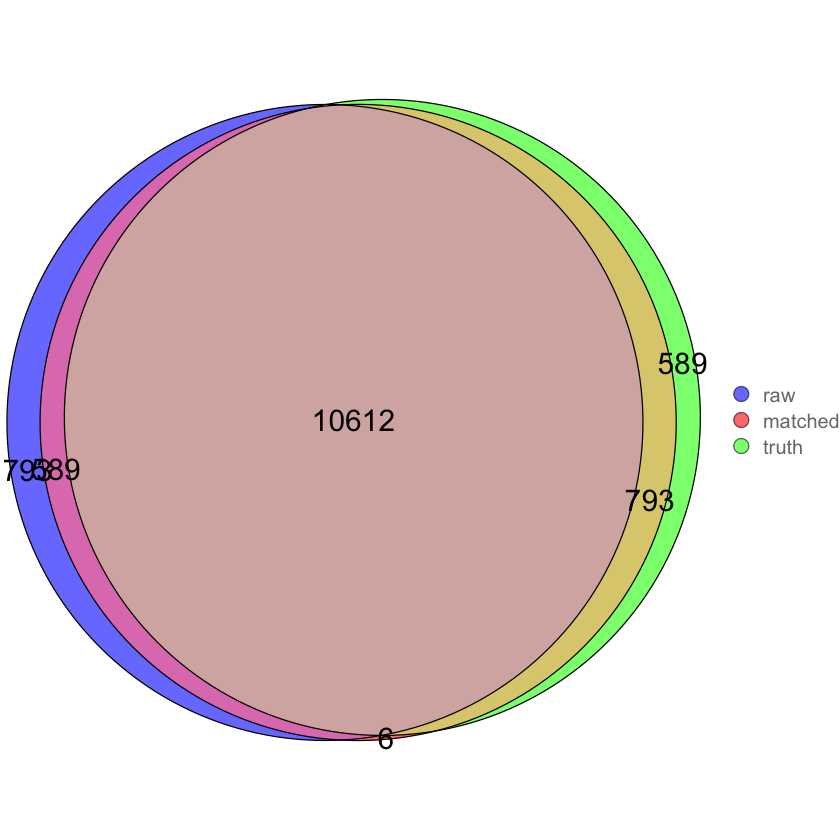

In [69]:
# label overlaps
library(eulerr)
var.subset_ = short.test.data %>% mutate(raw=paste(PatientID, VariantID, raw.label, sep=":"),
                                    matched=paste(PatientID, VariantID, matched.label, sep=":"),
                                    truth=paste(PatientID, VariantID, truth.label, sep=":")) #%>%
#filter(truth.label=="CHIP")
dat = list(raw = var.subset_$raw,
           matched = var.subset_$matched,
           truth = var.subset_$truth)
colors = c("raw" = "blue",
           "matched" = "red",
           "truth" = "green")


v <- euler(dat) # function converts list to alphabetical order by label
eulerr_options(padding = unit(5, "mm"))
plot(v, quantities = list(type = "counts", cex=1.5),
     fills = list(fill = colors, alpha=0.6),
     legend = TRUE)

v$original.values


# Only 6 variant overlap between raw & truth

In [80]:
#taken from Fairchild et al. 2023.
get.performance <- function(preds, true_class, probs){
  test_roc <- roc(as.factor(true_class) ~ as.numeric(probs), plot=T)
  print(table(true_class, preds))
  #confusion <- table(as.factor(preds), as.factor(true_class))
  #   tp <- confusion["CHIP","CHIP"]
  #   fp <- confusion["CHIP","not.CHIP"]
  #   tn <- confusion["not.CHIP","not.CHIP"]
  #   fn <- confusion["not.CHIP","CHIP"]
  tp <- sum(preds=="somatic" & true_class=="somatic")
  fp <- sum(preds=="somatic" & true_class=="germline")
  tn <- sum(preds=="germline" & true_class=="germline")
  fn <- sum(preds=="germline" & true_class=="somatic")
  
  precision <- tp / (tp+fp) 
  recall <- TPR <- tp / (tp + fn) # aka sensitivity
  TNR <- tn / (tn + fp) # aka specificity
  
  f1 <- 2 * ((precision * recall) / (precision + recall))
  bacc <- (TPR + TNR) / 2
  
  res <- data.frame(tp=tp,fp=fp,tn=tn,fn=fn,prec=precision,sens=recall,spec=TNR,f1=f1,bacc=bacc, roc=test_roc$auc)
  print(res)
  return(res)
}

model_outputs <- function(model, spec=NA) {
  CVPerf <- getTrainPerf(model) 
  CVROC <- CVPerf[,1]
  #print(model$bestTune)
  bestAlpha <- model$bestTune[,1]
  bestLambda <- model$bestTune[,2]
  stats = model$pred
  #print(stats)
  CI.95 = ci.auc(stats$obs, stats$somatic)
  #CI.90 = ci.auc(stats$obs, stats$MI.NOC, conf.level=0.9)
  #out = get_sens_at_spec(model, spec)
  print(sprintf("ROC: %s", round(CVROC,2)))
  print("AUC 95 CI:")
  print(CI.95)
  #     print("AUC 90 CI:")
  #     print(CI.90)
  print(coef(model$finalModel, s=bestLambda))
  
  return(stats)
}

          
           somatic germline
  somatic      625        6
  germline     793    10576

Setting levels: control = somatic, case = germline

Setting direction: controls > cases



          preds
true_class somatic germline
  somatic      625        6
  germline     793    10576
   tp  fp    tn fn      prec      sens      spec        f1      bacc       roc
1 625 793 10576  6 0.4407616 0.9904913 0.9302489 0.6100537 0.9603701 0.9603701


          
           somatic germline
  somatic       36        0
  germline    1382    10582

Setting levels: control = somatic, case = germline

Setting direction: controls > cases



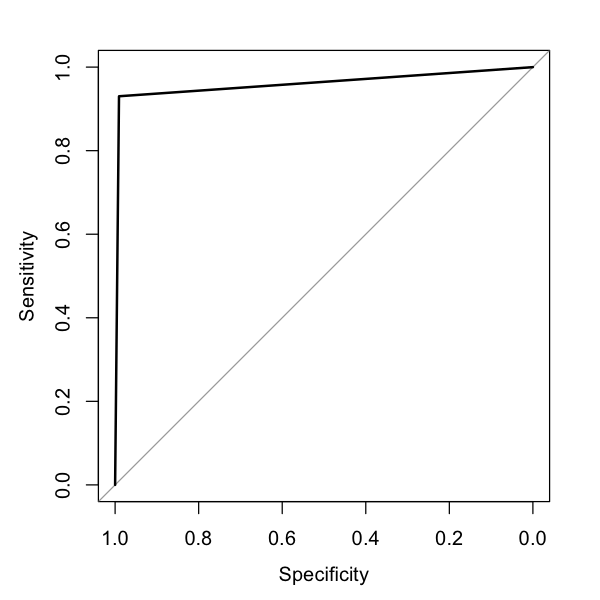

          preds
true_class somatic germline
  somatic       36        0
  germline    1382    10582
  tp   fp    tn fn       prec sens      spec         f1      bacc       roc
1 36 1382 10582  0 0.02538787    1 0.8844868 0.04951857 0.9422434 0.9422434


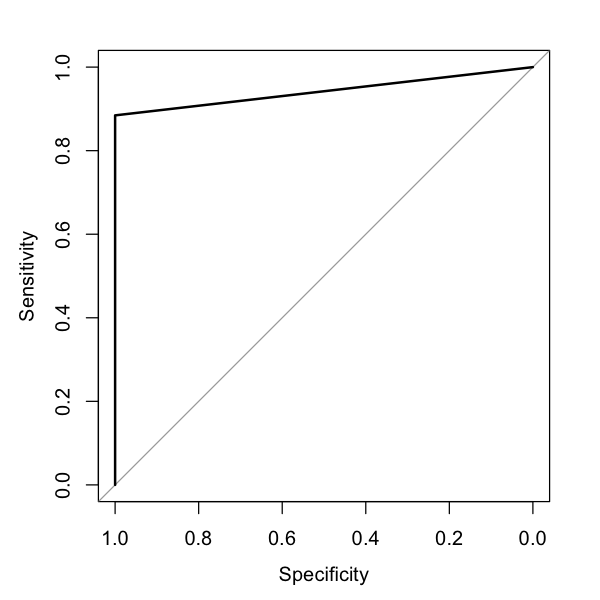

In [71]:
## current prediction ability without matched germline:
options(repr.plot.width=5, repr.plot.height=5)

var.subset <- short.test.data

# raw predictions vs. germline matched predictions -- sens=0% spec=99.5%
table(var.subset$matched.label, var.subset$raw.label)

baseline.stats.matched <- get.performance(preds=var.subset$raw.label,
                                          true_class=var.subset$matched.label,
                                          probs = ifelse(var.subset$raw.label=="somatic",1.0,0.0))

# raw.predictions vs. truth.labels - AUC=0.0
table(var.subset$truth.label, var.subset$raw.label)
baseline.stats.truth <- get.performance(preds=var.subset$raw.label,
                                        true_class=var.subset$truth.label,
                                        probs = ifelse(var.subset$raw.label=="somatic",1.0,0.0))

In [75]:
## model trained on truth.labels (a la fairchild)
library(glmnet)

eGrid <- expand.grid(.alpha=1,.lambda=seq(0,1,by=0.01)) #alpha=0-1ridge/lasso, #lambda=weight of regularization
Control <- trainControl(verboseIter=FALSE, classProbs=TRUE, summaryFunction=twoClassSummary, 
                        method="cv", number=5, savePredictions="final")

selCols = c('matched.label','PatientID','sampleNames','Germ.VariantFreq','in.pbmc','Tumor.VariantFreq',
            'in.tumor', 'VariantID', 'Tumor.VariantType', 'Sex') # Note I added some more columns for this model
subset.sel = var.subset %>% select(-selCols)
names(subset.sel)

Adding missing grouping variables: `PatientID`


[1] "PatientID"               "ref"                    
 [3] "alt"                     "totalDepth"             
 [5] "refDepth"                "altDepth"               
 [7] "SYMBOL"                  "IMPACT"                 
 [9] "VARIANT_CLASS"           "filteredCnt"            
[11] "DSCnt"                   "filteredDSCnt"          
[13] "Qscore"                  "avgEntropy"             
[15] "filtered_tlen_mean"      "tlen.ratio"             
[17] "repeatRegion"            "white.list"             
[19] "MNV"                     "GC.Percent"             
[21] "tandemRepeat"            "highQ.ratio"            
[23] "CopyNumber"              "zScore.cnv"             
[25] "filterScore"             "highFrequent.inbatch"   
[27] "VariantType.old"         "gene.n.mutations.cohort"
[29] "Plasma.VariantFreq"      "raw.label"              
[31] "truth.label"             "Treatment.Arm"          
[33] "Age"                     "synonymous"             
[35] "medianVAF"               "pathogenic"             
[37] "has.covariant"           "somaticVAFratio"        
[39] "VAF.zscore"              "VAF.zscore.abs"         
[41] "context"                 "mutType"                
[43] "mutMotif"                "t_maj"                  
[45] "max_COSMIC_CNT"          "allVarCount"            
[47] "Consequence"

Setting levels: control = somatic, case = germline

Setting direction: controls > cases



[1] "ROC: 0.75"
[1] "AUC 95 CI:"
95% CI: 0.6611-0.7988 (DeLong)
1032 x 1 sparse Matrix of class "dgCMatrix"
                                                                          s1
(Intercept)                                                        .        
(Intercept)                                                        .        
PatientID171126                                                    .        
PatientID171660                                                    .        
PatientID172109                                                    .        
PatientID172163                                                    .        
PatientID172422                                                    .        
PatientID172592                                                    .        
PatientID172956                                                    .        
PatientID173129                                                    .        
PatientID173149                              

alpha,lambda,pred,obs,rowIndex,somatic,germline,Resample
<dbl>,<dbl>,<fct>,<fct>,<int>,<dbl>,<dbl>,<chr>
1,1,germline,germline,6223,0.006679605,0.9933204,Fold2
1,1,germline,germline,6199,0.006679605,0.9933204,Fold2
1,1,germline,somatic,6224,0.006679605,0.9933204,Fold2
1,1,germline,germline,6217,0.006679605,0.9933204,Fold2
1,1,germline,germline,6364,0.006679605,0.9933204,Fold2
1,1,germline,germline,6200,0.006679605,0.9933204,Fold2
1,1,germline,germline,6216,0.006679605,0.9933204,Fold2
1,1,germline,germline,6397,0.006679605,0.9933204,Fold2
1,1,germline,germline,6367,0.006679605,0.9933204,Fold2


Setting levels: control = somatic, case = germline

Setting direction: controls < cases



          preds
true_class somatic germline
  somatic        0       36
  germline       0    11964
  tp fp    tn fn prec sens spec  f1 bacc       roc
1  0  0 11964 36  NaN    0    1 NaN  0.5 0.7535384


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `model.truth.prediction = predict(model.2f)`.
[36mℹ[39m In group 1: `PatientID = "170762"`.
[1mCaused by error:[22m
[1m[22m[33m![39m `model.truth.prediction` must be size 600 or 1, not 12000.


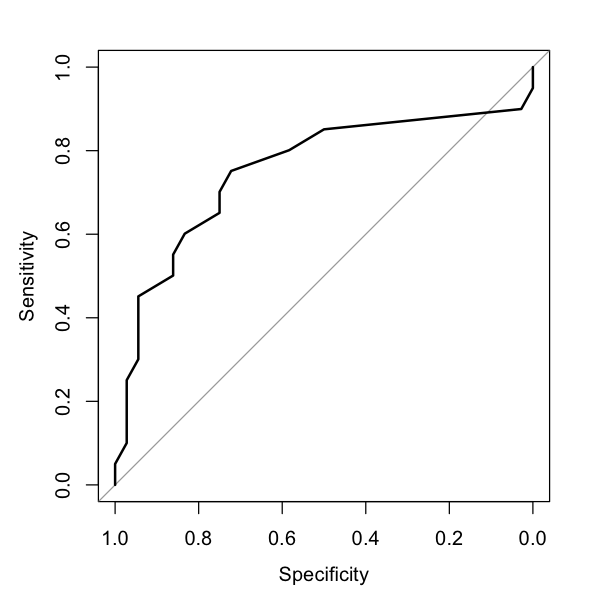

In [81]:
# finds optimal intercept
# worse performing, fewer signif features, AUC=0.81 sens = 0%
# model.2f <- train(truth.label ~ ., subset.sel, metric = "ROC", 
#                         tuneGrid=eGrid, trControl = Control, method = "glmnet", intercept=TRUE)
# no intercept model also not better

x_vars <- model.matrix(truth.label ~ ., subset.sel) # sets the intercept to = 1
model.2f <- train(y = subset.sel$truth.label, x = x_vars, metric = "ROC", 
                       tuneGrid=eGrid, trControl = Control, method = "glmnet", intercept=FALSE)

model_outputs(model.2f)
model.2f.stats <- get.performance(predict(model.2f), 
                                  subset.sel$truth.label, 
                                  predict(model.2f, type = "prob")[,2])

var.subset.annot = var.subset %>% mutate(model.truth.prediction=predict(model.2f))

# SMOTE 

# ERROR:
> var.subset.annot = var.subset %>% mutate(model.truth.prediction=predict(model.2f))
Error in `mutate()`:
ℹ In argument: `model.truth.prediction = predict(model.2f)`.
ℹ In group 1: `PatientID = "170762"`.
Caused by error:
! `model.truth.prediction` must be size 600 or 1, not 12000.
Run `rlang::last_trace()` to see where the error occurred.